In [32]:
############################
# GPU and CPU Check Code
# KEEP AT THE TOP
############################

# !pip install psutil
# !pip install gputil

import psutil
import torch
import os
import spacy

from tqdm import tqdm
from transformers import BertTokenizer, BertForMaskedLM, LineByLineTextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments

import psutil

# Get the number of CPUs
num_cpus = psutil.cpu_count(logical=False)  # physical cores
num_logical_cpus = psutil.cpu_count(logical=True)  # logical cores

print(f"Number of physical CPUs: {num_cpus}")
print(f"Number of logical CPUs: {num_logical_cpus}")

try:
    import GPUtil

    # Get the number of available GPUs
    gpus = GPUtil.getGPUs()
    num_gpus = len(gpus)

    print(f"Number of GPUs: {num_gpus}")

    for i, gpu in enumerate(gpus):
        print(f"GPU {i + 1}: {gpu.name}")
        print(f"\tMemory Total: {gpu.memoryTotal} MB")
        print(f"\tMemory Used: {gpu.memoryUsed} MB")
        print(f"\tMemory Free: {gpu.memoryFree} MB")
        print(f"\tGPU Utilization: {gpu.load * 100}%")
        print(f"\tGPU Temperature: {gpu.temperature} °C")
except ImportError:
    print("GPUtil library not found. Cannot check GPU information.")

Number of physical CPUs: 128
Number of logical CPUs: 128
Number of GPUs: 2
GPU 1: NVIDIA A100 80GB PCIe
	Memory Total: 81920.0 MB
	Memory Used: 17335.0 MB
	Memory Free: 63715.0 MB
	GPU Utilization: 0.0%
	GPU Temperature: 56.0 °C
GPU 2: NVIDIA A100 80GB PCIe
	Memory Total: 81920.0 MB
	Memory Used: 7.0 MB
	Memory Free: 81042.0 MB
	GPU Utilization: 0.0%
	GPU Temperature: 26.0 °C


In [1]:
# # USE ONLY TO EXTRACT FILES FROM TAR FILES

import tarfile

def extract_all_files(tar_file_path, extract_to):
    with tarfile.open(tar_file_path, 'r') as tar:
        tar.extractall(extract_to)

# Example usage
tar_file_path = 'datasets/sogou_news_csv.tar.gz'
extract_to = 'datasets/'
extract_all_files(tar_file_path, extract_to)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/data/user/cwalia/Conda_Env/nlp2023v2/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used 

Testing Accuracy: 0.9089473684210526


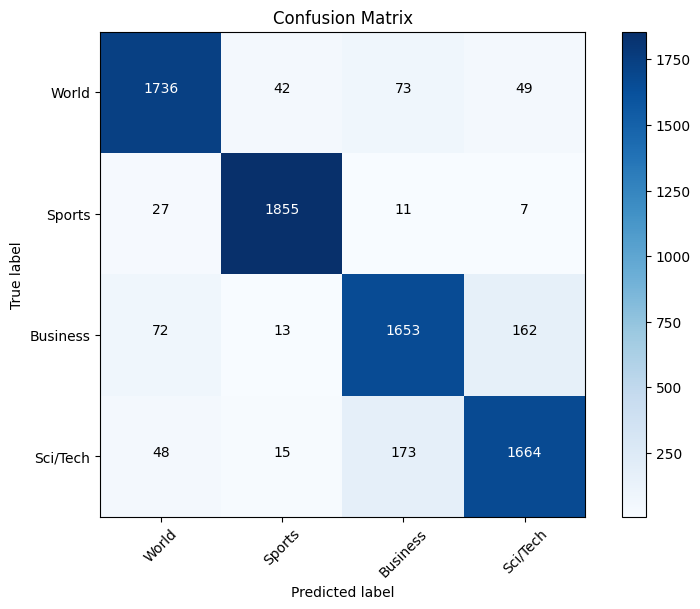

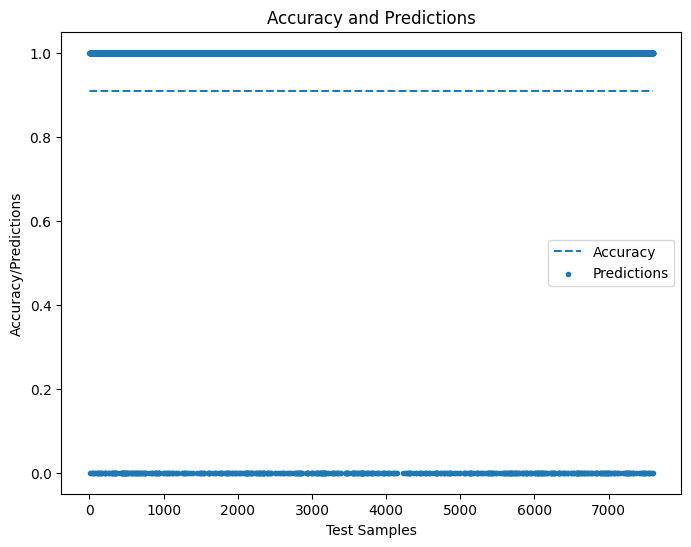

In [45]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Load classes
with open('datasets/ag_news_csv/classes.txt', 'r') as classes_file:
    classes = [line.strip() for line in classes_file.readlines()]

# Load train and test data, handling parsing errors by skipping problematic lines
train_df = pd.read_csv('datasets/ag_news_csv/train.csv', header=None, names=['class_index', 'title', 'description'])
test_df = pd.read_csv('datasets/ag_news_csv/test.csv', header=None, names=['class_index', 'title', 'description'])

# BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenize and prepare input sequences for BERT
def prepare_input_sequences(df):
    input_ids = []
    attention_masks = []

    for index, row in df.iterrows():
        if len(row) != 3:  # Skip rows with incorrect number of fields
            continue

        title = row[1].replace('""', '"')  # Unescape double quotes in title
        description = row[2].replace('""', '"')  # Unescape double quotes in description

        # Combine title and description with [SEP] token
        text = f"{title} [SEP] {description}"

        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=256,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

# Prepare input sequences for train and test data separately
train_input_ids, train_attention_masks = prepare_input_sequences(train_df)
test_input_ids, test_attention_masks = prepare_input_sequences(test_df)

# Define BERT model
model = BertModel.from_pretrained('bert-base-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Extract BERT embeddings
def extract_embeddings(input_ids, attention_masks):
    embeddings = []

    for i in range(0, len(input_ids), 100):  # Process in batches due to memory constraints
        with torch.no_grad():
            inputs = input_ids[i:i+100].to(device)
            masks = attention_masks[i:i+100].to(device)
            outputs = model(inputs, attention_mask=masks)
            last_hidden_states = outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token embedding
            embeddings.append(last_hidden_states.cpu())

    return torch.cat(embeddings, dim=0)

# Extract embeddings for train and test data
train_embeddings = extract_embeddings(train_input_ids, train_attention_masks)
test_embeddings = extract_embeddings(test_input_ids, test_attention_masks)

# Convert class indices to numpy arrays
train_labels = np.array(train_df['class_index'] - 1)
test_labels = np.array(test_df['class_index'] - 1)

# Train a simple classifier on top of BERT embeddings (Logistic Regression for example)
classifier = LogisticRegression(max_iter=1000)
classifier.fit(train_embeddings, train_labels)

# Predict using the classifier
predictions = classifier.predict(test_embeddings)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)
print(f"Testing Accuracy: {accuracy}")

# Plot confusion matrix
conf_mat = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(conf_mat[i][j]), horizontalalignment="center", color="white" if conf_mat[i][j] > conf_mat.max() / 2 else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Plotting accuracy
plt.figure(figsize=(8, 6))
plt.plot([accuracy] * len(test_labels), label='Accuracy', linestyle='--')
plt.scatter(range(len(test_labels)), (predictions == test_labels).astype(int), marker='.', label='Predictions')
plt.xlabel('Test Samples')
plt.ylabel('Accuracy/Predictions')
plt.title('Accuracy and Predictions')
plt.legend()
plt.show()


In [46]:
# Define model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(classes))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Prepare tensors for DataLoader
train_labels = torch.tensor(train_df['class_index'] - 1)  # Adjust class index to start from 0

# DataLoader
batch_size = 32
train_data = TensorDataset(train_input_ids, train_attention_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Fine-tuning
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_masks, labels = batch

        model.zero_grad()
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs} - Average Training Loss: {avg_train_loss}")

# Evaluation on test data
# Evaluation on test data
test_labels = torch.tensor(test_df['class_index'] - 1)  # Adjust class index to start from 0
test_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

model.eval()
total_eval_accuracy = 0
predictions_list = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, attention_masks, labels = batch

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits

    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()
    predictions = np.argmax(logits, axis=1)
    total_eval_accuracy += (predictions == label_ids).mean()
    predictions_list.extend(predictions)

avg_accuracy = total_eval_accuracy / len(test_dataloader)
print(f"Average Testing Accuracy: {avg_accuracy}")

# Calculate confusion matrix
# conf_mat = confusion_matrix(test_labels, predictions_list)
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

# # Plotting accuracy and predictions
# plt.figure(figsize=(8, 6))
# plt.plot([avg_accuracy] * len(test_labels), label='Accuracy', linestyle='--')
# plt.scatter(range(len(test_labels)), (predictions_list == test_labels).astype(int), marker='.', label='Predictions')
# plt.xlabel('Test Samples')
# plt.ylabel('Accuracy/Predictions')
# plt.title('Accuracy and Predictions')
# plt.legend()
# plt.show()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1/3 - Average Training Loss: 0.21024938592215378
Epoch 2/3 - Average Training Loss: 0.1280215780497839
Epoch 3/3 - Average Training Loss: 0.08619334326653431
Average Testing Accuracy: 0.9470850840336135


NameError: name 'sns' is not defined

<Figure size 800x600 with 0 Axes>

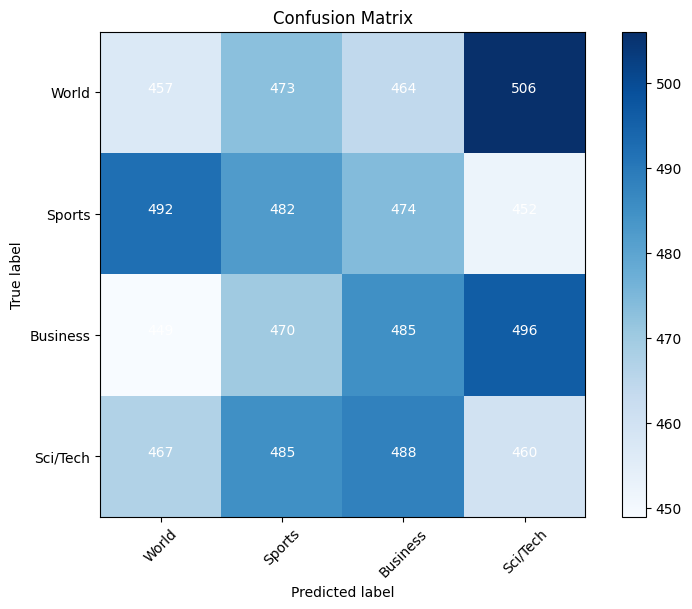

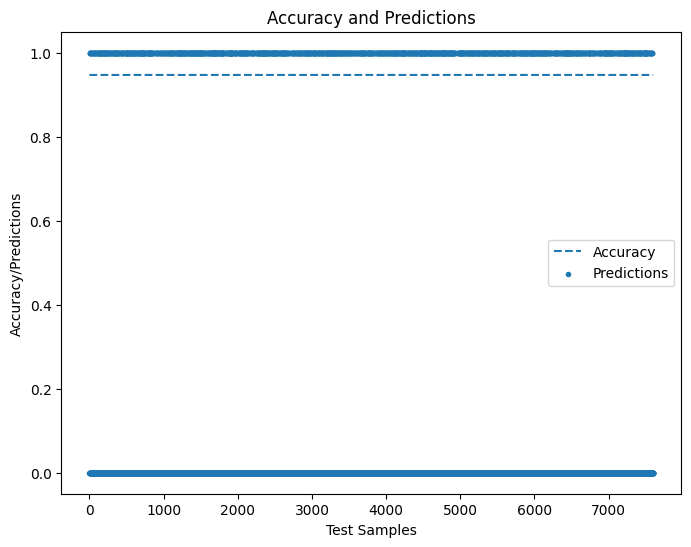

In [49]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Calculate confusion matrix
conf_mat = confusion_matrix(test_labels, predictions_list)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(conf_mat[i][j]), horizontalalignment="center", color="white" if conf_mat[i][j] > conf_mat.max() / 2 else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Convert predictions_list and test_labels to NumPy arrays
predictions_array = np.array(predictions_list)
test_labels_array = test_labels.numpy()  # Assuming test_labels is a tensor

# Plotting accuracy and predictions
plt.figure(figsize=(8, 6))
plt.plot([avg_accuracy] * len(test_labels), label='Accuracy', linestyle='--')
plt.scatter(range(len(test_labels)), (predictions_array == test_labels_array).astype(int), marker='.', label='Predictions')
plt.xlabel('Test Samples')
plt.ylabel('Accuracy/Predictions')
plt.title('Accuracy and Predictions')
plt.legend()
plt.show()

